# Model Selection and Evaluation

This notebook demonstrates functionality for evaluating and analyzing trained model performance. 

**Note:** In order to run this notebook, you will need to have the full dataset downloaded from Kaggle and saved to the `/home/cdsw/data` directory. The data is automatically downloaded and unzipped for you by providing your Kaggle credentials (username & API key) during the configuration step of this AMP. 

In [ ]:
import os
import json
import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.model import unet_model
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from src.data_utils import (
    plot_sample_batch,
    create_mask,
    plot_samples_by_class,
    get_dataset_path,
)
from src.model_utils import (
    dice_coef,
    dice_coef_per_class,
    evaluate_per_class,
    collect_experiment_scores,
)


%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Select Best Model

Lets gather results from our hyperparameter search experiments to see which model performs best. Here, we'll select the best experiment based on that which has the highest validation dice coefficient score. For more details on training experiments, see `/scripts/train_experiment.py`.

In [2]:
LOG_DIR = "/home/cdsw/logs"
experiment_scores = collect_experiment_scores(log_dir=LOG_DIR)
experiment_scores

,experiment,val_dice_score,val_loss
0,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.707200,0.092340
1,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.708257,0.087732
2,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.688830,0.088828
3,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.670652,0.094232
4,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.660426,0.089942
5,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.661949,0.099816
6,unet-epochs_200-lr_0.01-channels_352-loss_cate...,0.699844,0.086641


In [3]:
# get best experiment
best_dice_exp_idx = experiment_scores["val_dice_score"].idxmax()
best_dice_exp = experiment_scores.iloc[best_dice_exp_idx].experiment
best_dice_exp

'unet-epochs_200-lr_0.01-channels_352-loss_categorical_crossentropy-small_sample_False-sw_True-strategy_ens-beta_0.99'

In [4]:
# get best model (last saved checkpoint) from experiment
model_name = os.listdir(os.path.join(LOG_DIR, best_dice_exp, "max_val_dice"))[-1]

## Evaluate Model

### Load test set and data pipeline

In [ ]:
BATCH_SIZE = 8
DATASET_DIR = get_dataset_path()
IMG_SHAPE = (256, 1600)
ANNOTATIONS_PATH = f"{DATASET_DIR}/train.csv"
TRAIN_IMG_PATH = f"{DATASET_DIR}/train_images"
LOSSES = {
    "categorical_crossentropy": tf.keras.losses.CategoricalCrossentropy(),
}
METRICS = {"dice_coef": dice_coef}
oversample_train_set = False
undersample_train_set = False

# instantiate dataset and pipelne
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
    test_size=0.1,
)

# create train/test & x/y splits
train_imgs = sd.train_imgs
test_imgs = sd.test_imgs

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,
        "cache": False,
        "shuffle_buffer_size": False,
        "batch_size": BATCH_SIZE,
        "prefetch": False,
    },
)

train_dataset = sdp(X_train, y_train, is_train=True)
test_dataset = sdp(X_test, y_test, is_train=False)

### Load model

In [6]:
MODEL_PATH = os.path.join("/home/cdsw/logs", best_dice_exp, "max_val_dice", model_name)
print(MODEL_PATH)
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

/home/cdsw/logs/unet-epochs_200-lr_0.01-channels_352-loss_categorical_crossentropy-small_sample_False-sw_True-strategy_ens-beta_0.99/max_val_dice/190-0.10-0.71-best_model.h5


#### Overall Metrics

Evaluate the test set with the best model and print out loss and dice coefficient score.

In [ ]:
metrics = unet_model.evaluate(test_dataset)

In [8]:
dict(zip(unet_model.metrics_names, metrics))

{'loss': 0.09937862306833267, 'dice_coef': 0.7000246644020081}

#### Dice Coef per class

Evaluate the test set with the best model and print out dice coefficient score per class.

In [ ]:
dice_per_class = evaluate_per_class(
    dataset=test_dataset, model=unet_model, metric=dice_coef_per_class
)

In [10]:
dice_per_class

{1: 0.6933743357658386, 2: 0.48934921622276306}

## Visualize Segmentation Predictions by Class

#### Predictions on test set

Batching
1/1 [==============================] - 0s 51ms/step


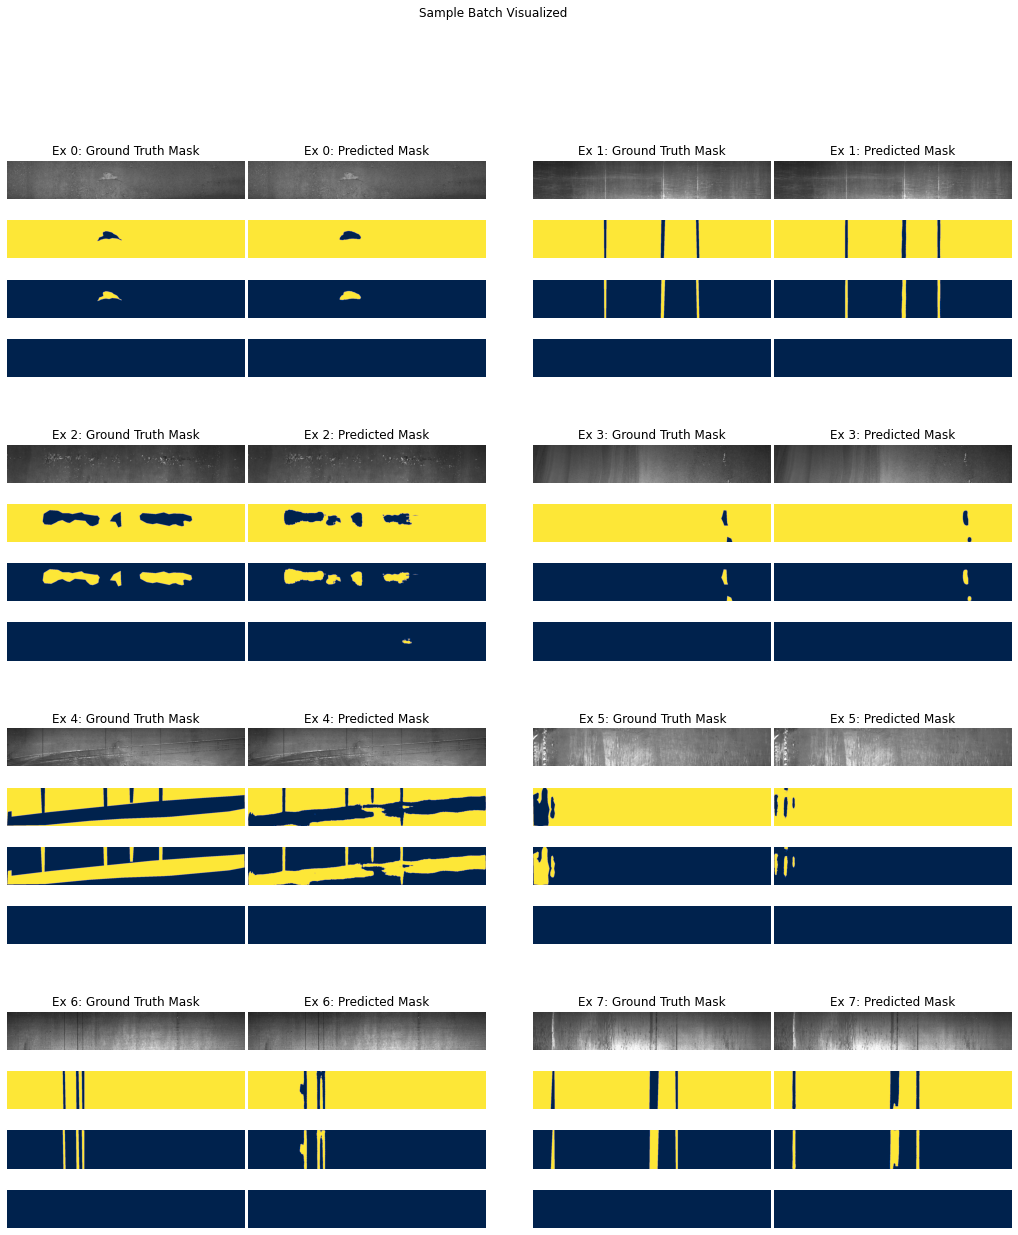

1/1 [==============================] - 0s 51ms/step


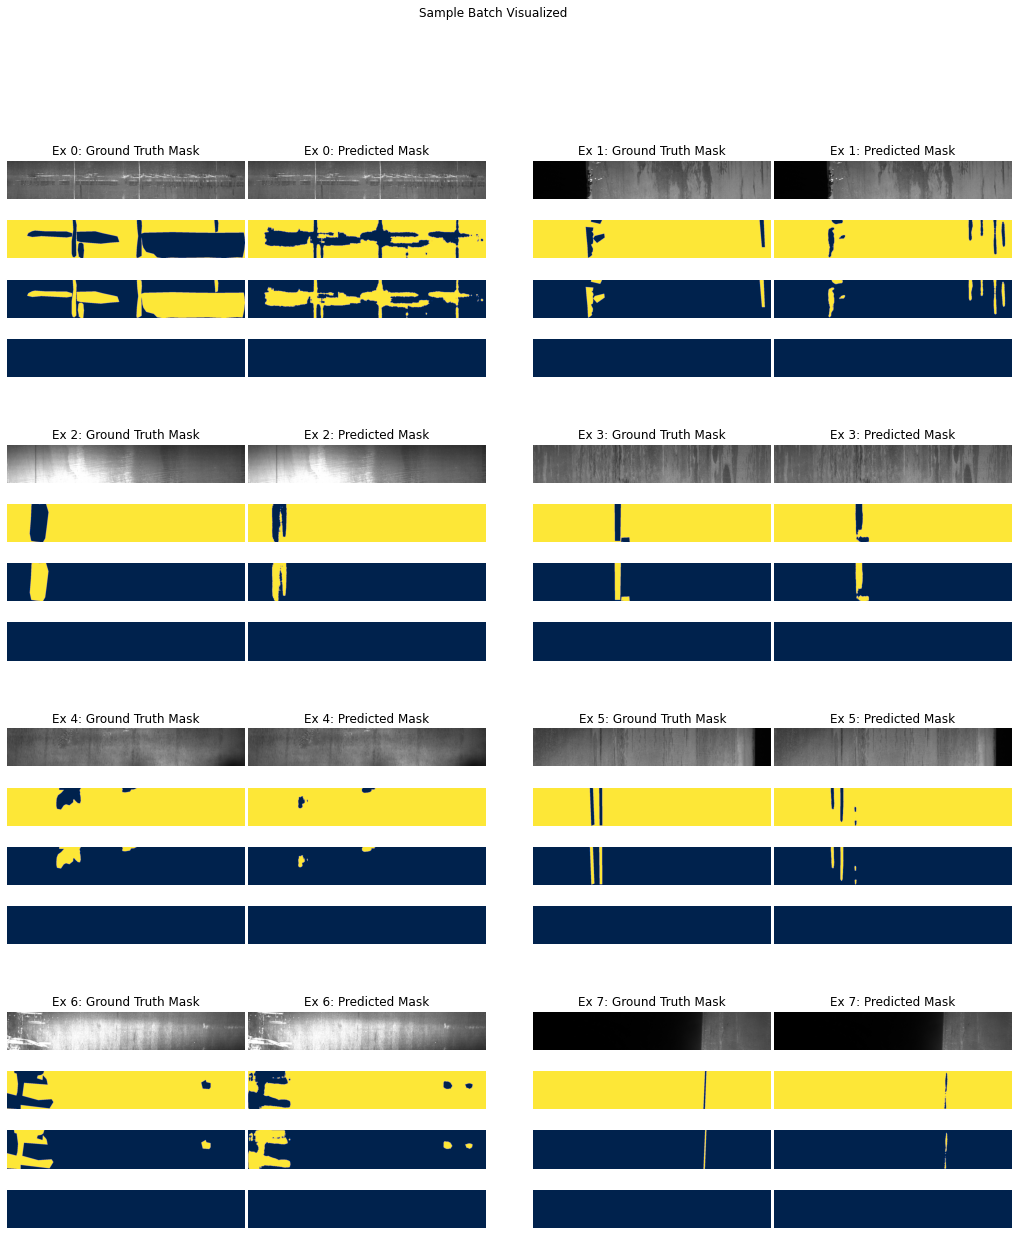

In [11]:
# class 3
plot_samples_by_class(
    class_idx=3, dataset=sd, pipeline=sdp, model=unet_model, n_batches=2, test_set=True
)

Batching
1/1 [==============================] - 0s 54ms/step


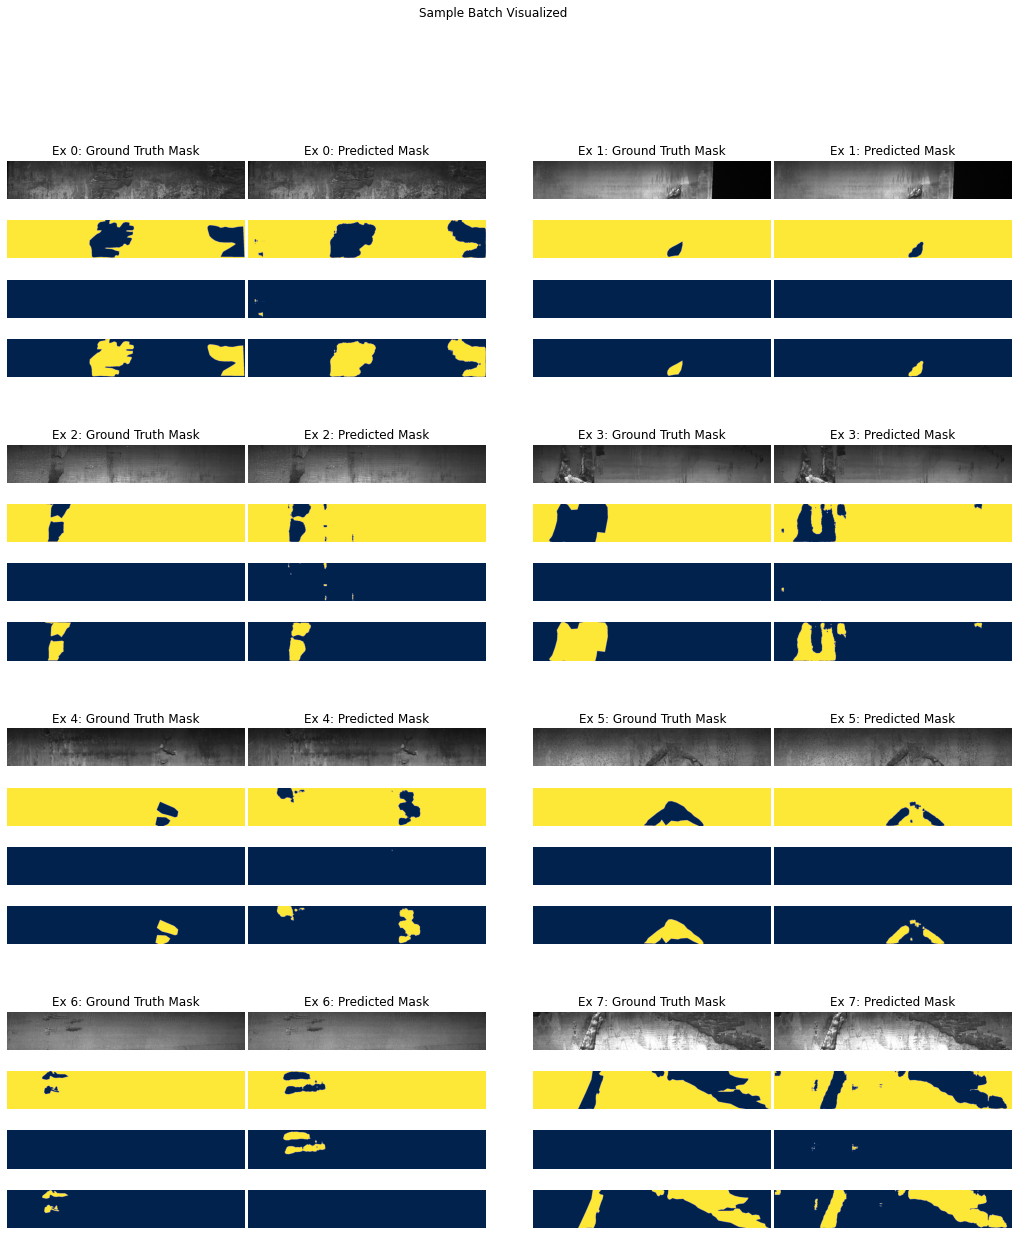

1/1 [==============================] - 0s 56ms/step


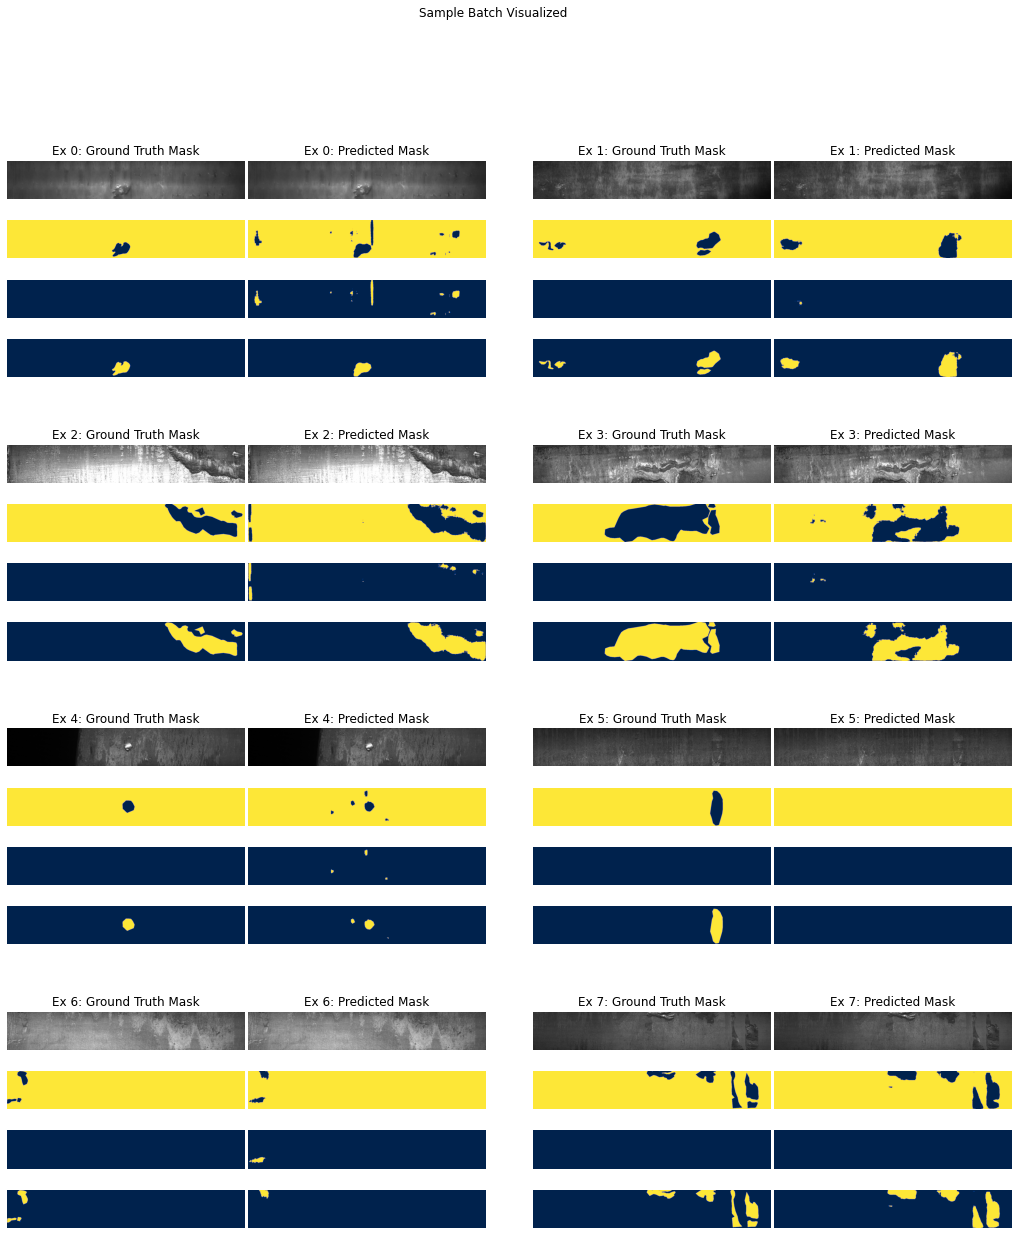

In [12]:
# class 4
plot_samples_by_class(
    class_idx=4, dataset=sd, pipeline=sdp, model=unet_model, n_batches=2, test_set=True
)

Batching
1/1 [==============================] - 0s 84ms/step


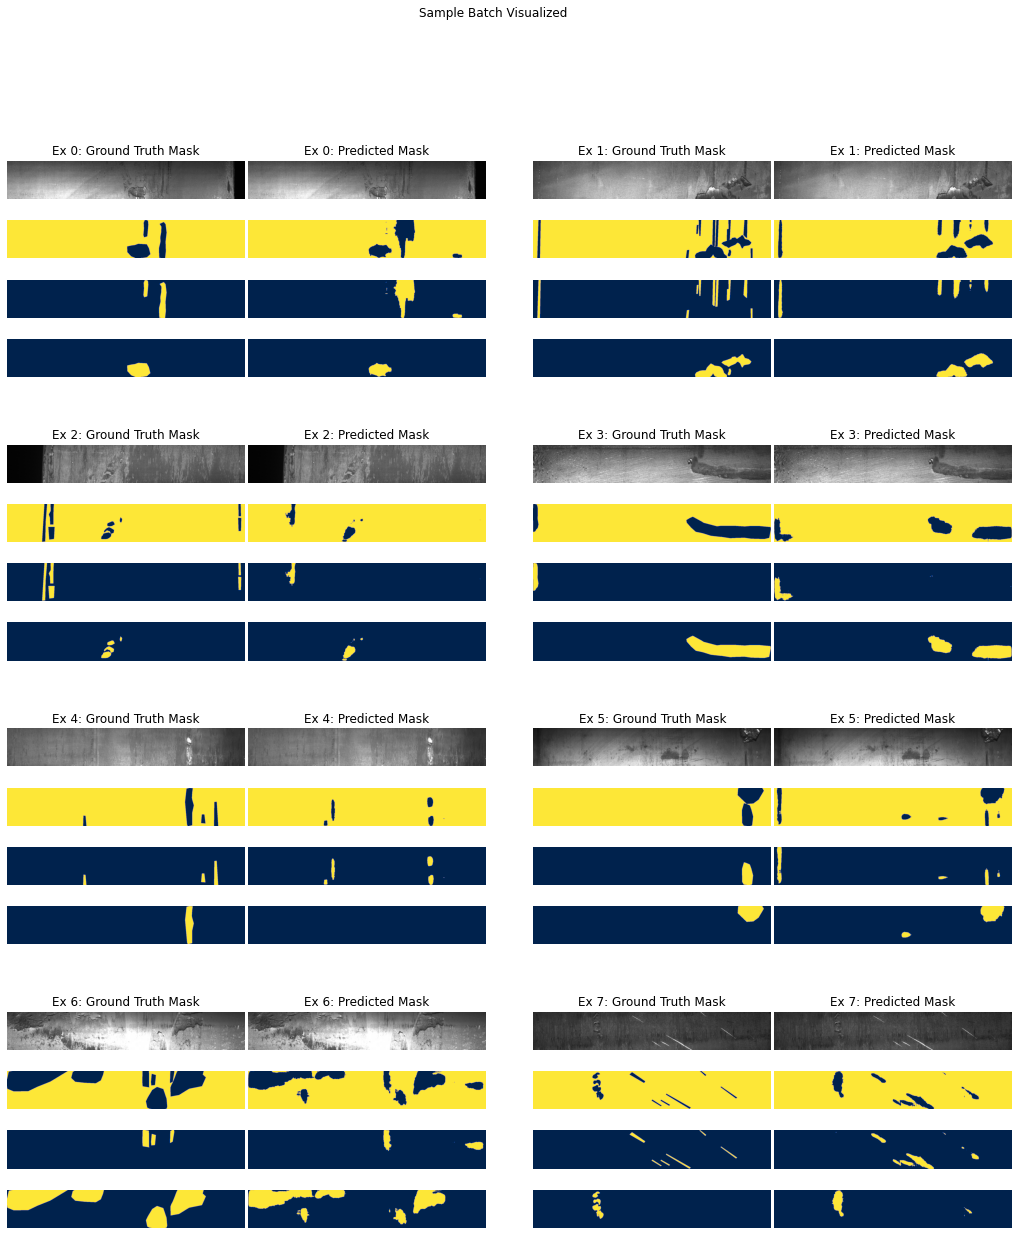

1/1 [==============================] - 0s 56ms/step


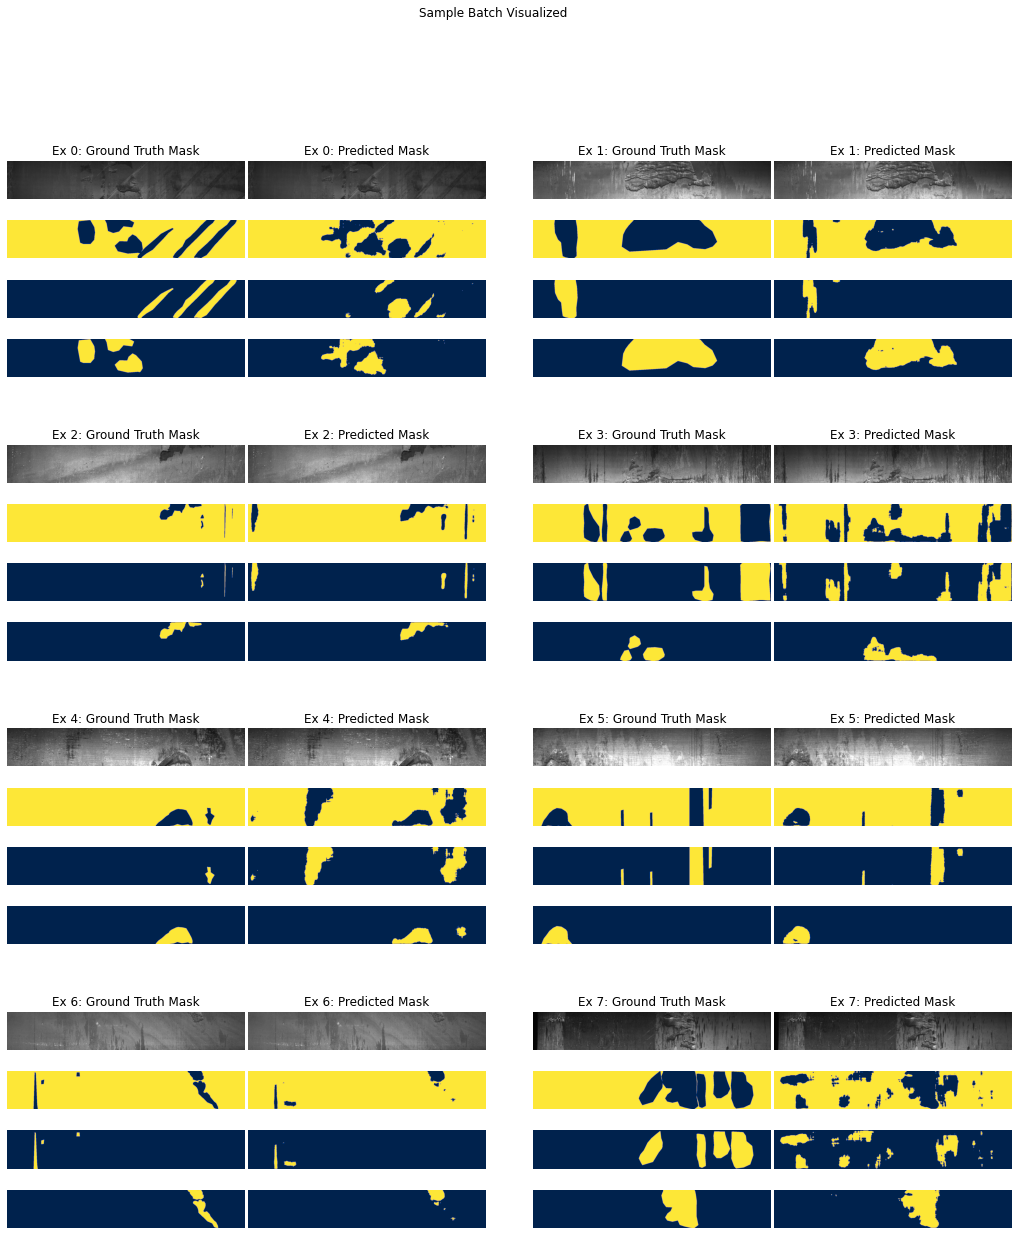

In [13]:
# class -2
plot_samples_by_class(
    class_idx=-2, dataset=sd, pipeline=sdp, model=unet_model, n_batches=2, test_set=True
)

**If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices. A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).**